In [1]:
import numpy as np, pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import statsmodels.api as sm
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from scipy import stats
from scipy.stats import normaltest
warnings.filterwarnings('ignore')
%matplotlib inline

In [2]:
# Importing the dataset
data = pd.read_csv('PT_Train.csv')

# Setting the 'Timestamp (GMT)' feature as an index for performing seasonal decomposition on the dataset
data = data.set_index('Timestamp (GMT)')
data.head(5)

,Lifetouch Heart Rate,Lifetouch Respiration Rate,Oximeter SpO2,Oximeter Pulse
Timestamp (GMT),,,,
17/08/2015 15:09,139,41,NaN,NaN
17/08/2015 15:10,144,40,92.0,140.0
17/08/2015 15:11,140,42,89.0,144.0
17/08/2015 15:12,138,45,93.0,141.0
17/08/2015 15:13,133,42,94.0,134.0


In [3]:
data.shape

(226, 4)

In [4]:
# Checking for null values in the dataset
data.isna().sum()

Lifetouch Heart Rate           0
Lifetouch Respiration Rate     0
Oximeter SpO2                 35
Oximeter Pulse                35
dtype: int64

In [5]:
# Removing null values from the feature columns containing null values
data = data.drop(data[data['Oximeter SpO2'].isna()].index)
data = data.drop(data[data['Oximeter Pulse'].isna()].index)
data.isna().sum()

Lifetouch Heart Rate          0
Lifetouch Respiration Rate    0
Oximeter SpO2                 0
Oximeter Pulse                0
dtype: int64

In [6]:
data.shape

(191, 4)

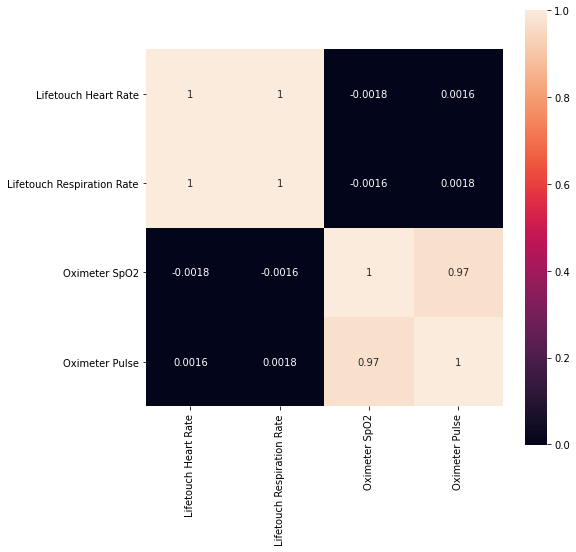

In [7]:
# Plotting a correlation matrix to understand the correlation between the features in the dataset to determine how much they...
# ...contribute to the dataset
plt.subplots(figsize=(8, 8))
sns.heatmap(data.corr(), annot=True, square=True)
plt.show()

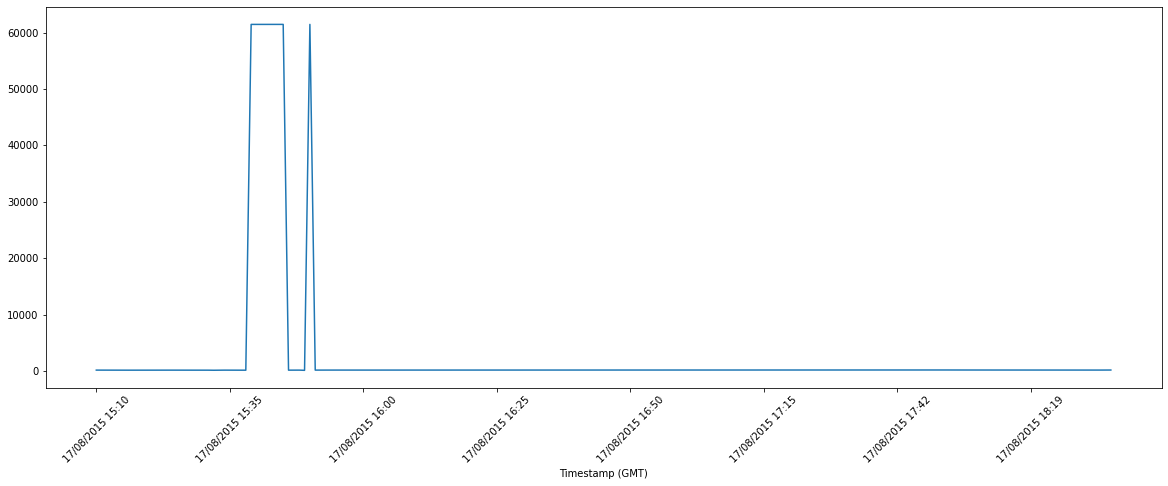

In [8]:
# Plotting the graph for each feature separately since each feature will be predicted separately
plt.figure(figsize = (20, 7))
data['Lifetouch Heart Rate'].plot()
plt.xticks(rotation = 45)
plt.show()

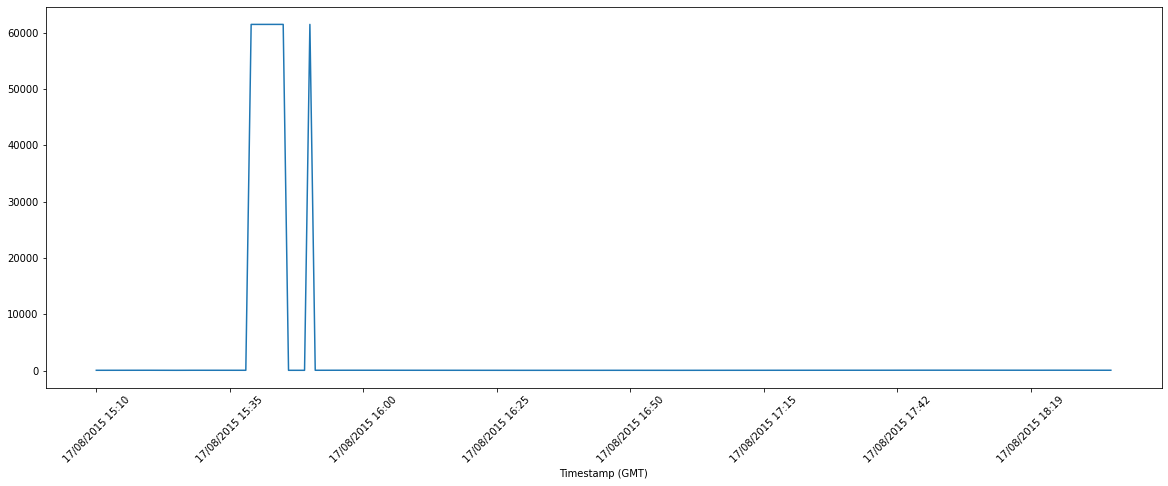

In [9]:
# Plotting the graph for each feature separately since each feature will be predicted separately
plt.figure(figsize = (20, 7))
data['Lifetouch Respiration Rate'].plot()
plt.xticks(rotation = 45)
plt.show()

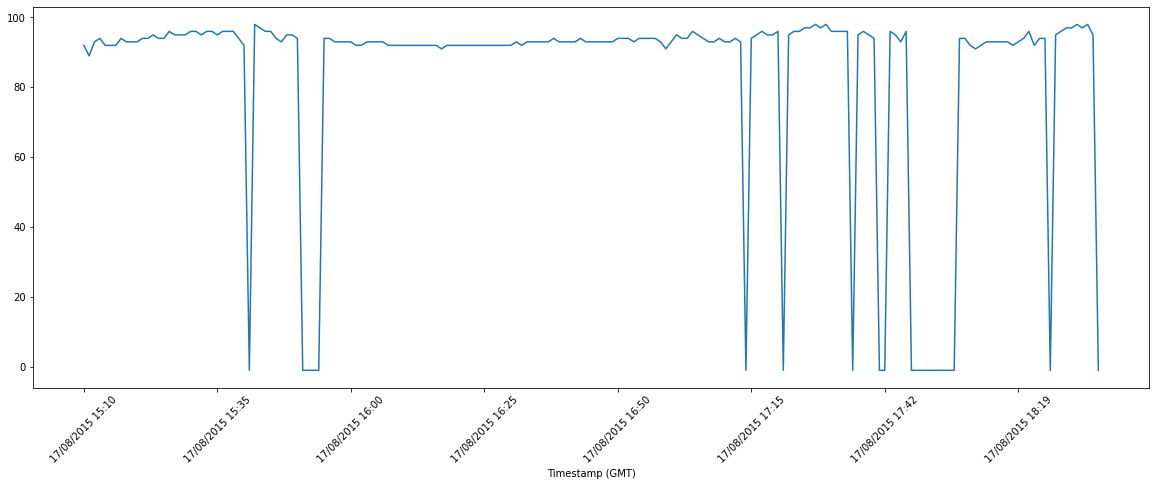

In [10]:
# Plotting the graph for each feature separately since each feature will be predicted separately
plt.figure(figsize = (20, 7))
data['Oximeter SpO2'].plot()
plt.xticks(rotation = 45)
plt.show()

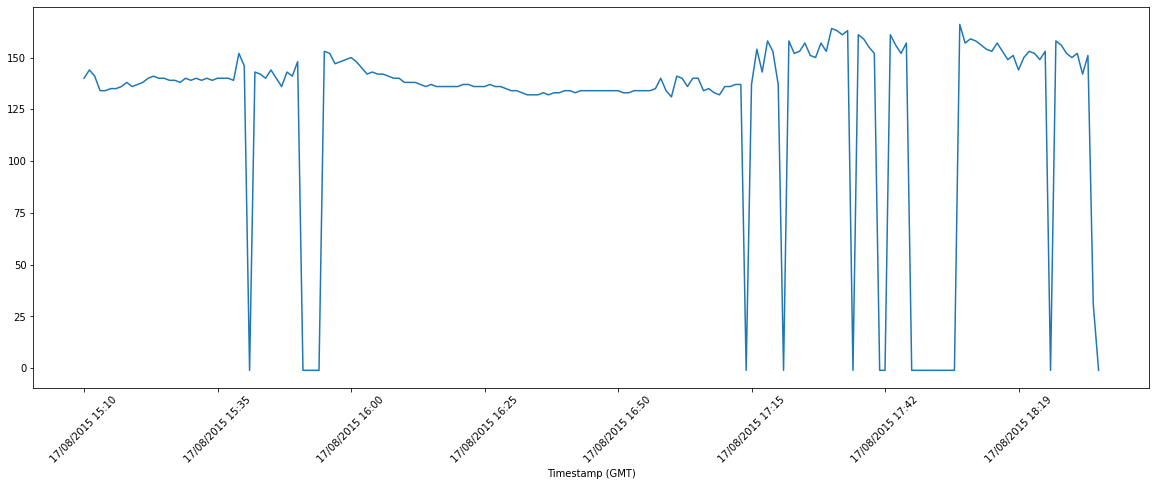

In [11]:
# Plotting the graph for each feature separately since each feature will be predicted separately
plt.figure(figsize = (20, 7))
data['Oximeter Pulse'].plot()
plt.xticks(rotation = 45)
plt.show()

<Figure size 432x288 with 0 Axes>

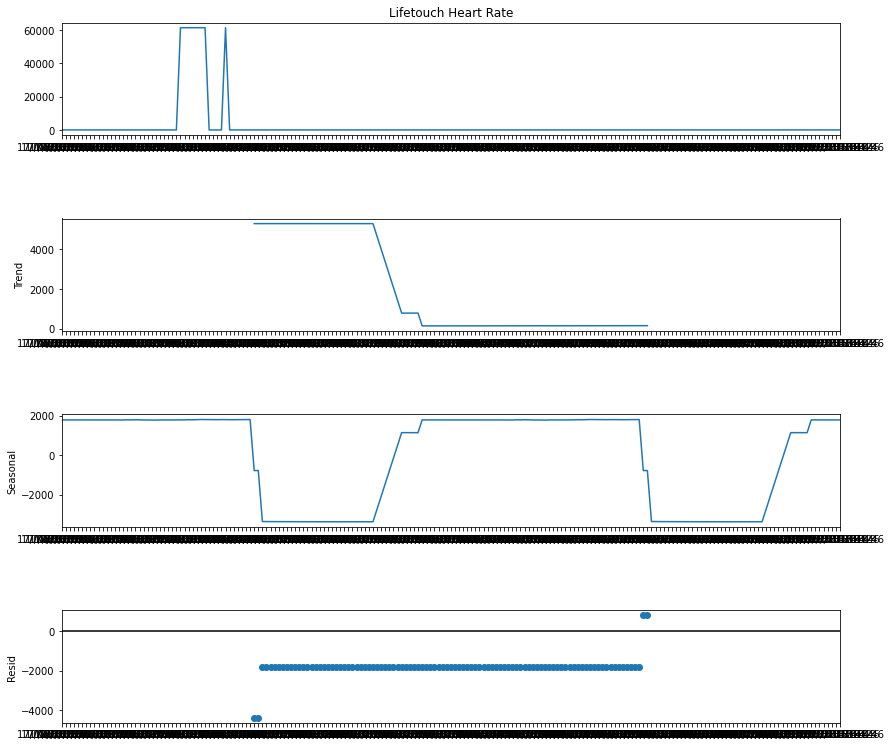

In [12]:
# Performing Seasonsal Decomposition for all features. Seasonal Decomposition separates the data based on a...
# ...repetitive pattern called season.
decomp_heart_rate = seasonal_decompose(data['Lifetouch Heart Rate'], model='additive', freq = 95)
fig = plt.figure()  
fig = decomp_heart_rate.plot()
fig.set_size_inches(15, 12)

<Figure size 432x288 with 0 Axes>

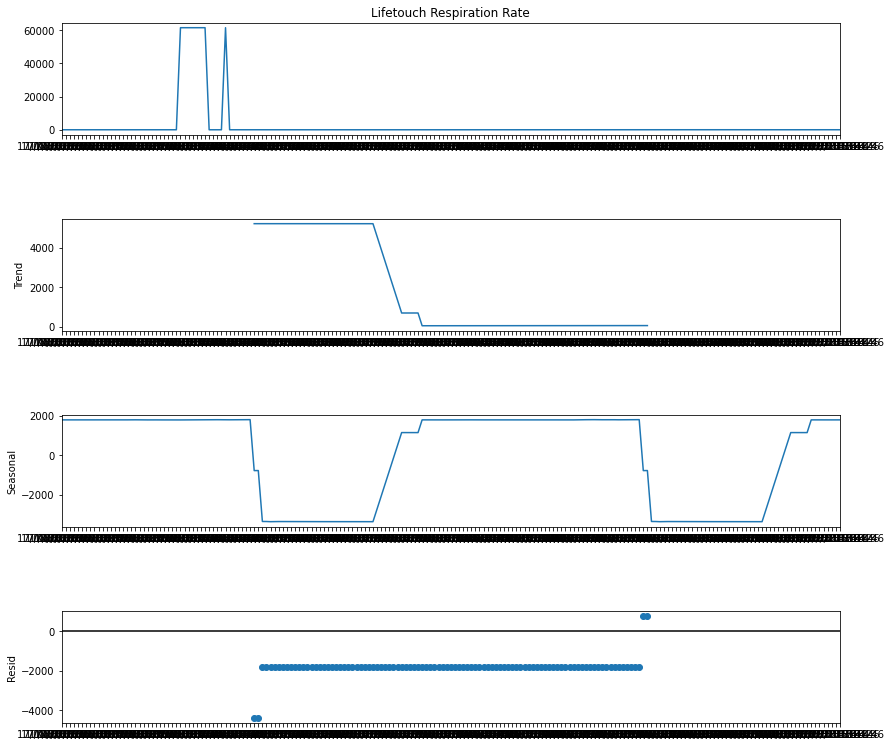

In [13]:
# Performing Seasonsal Decomposition for all features. Seasonal Decomposition separates the data based on a...
# ...repetitive pattern called season.
decomp_resp_rate = seasonal_decompose(data['Lifetouch Respiration Rate'], model='additive', freq = 95)
fig = plt.figure()  
fig = decomp_resp_rate.plot()  
fig.set_size_inches(15, 12)

<Figure size 432x288 with 0 Axes>

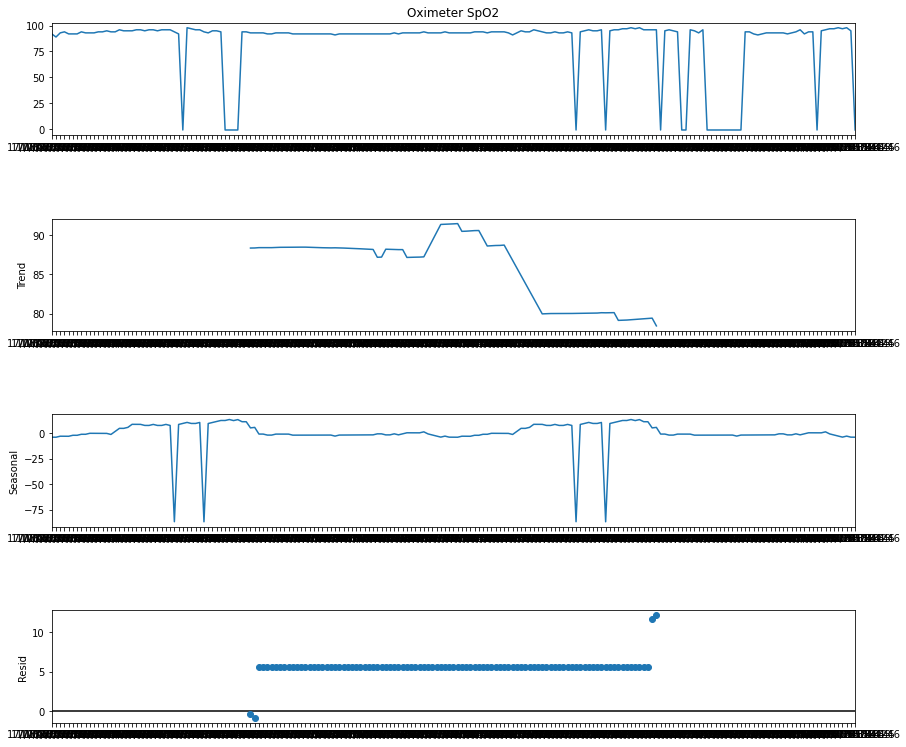

In [14]:
# Performing Seasonsal Decomposition for all features. Seasonal Decomposition separates the data based on a...
# ...repetitive pattern called season.
spo2 = seasonal_decompose(data['Oximeter SpO2'], model='additive', freq = 95)
fig = plt.figure()  
fig = spo2.plot()  
fig.set_size_inches(15, 12)

<Figure size 432x288 with 0 Axes>

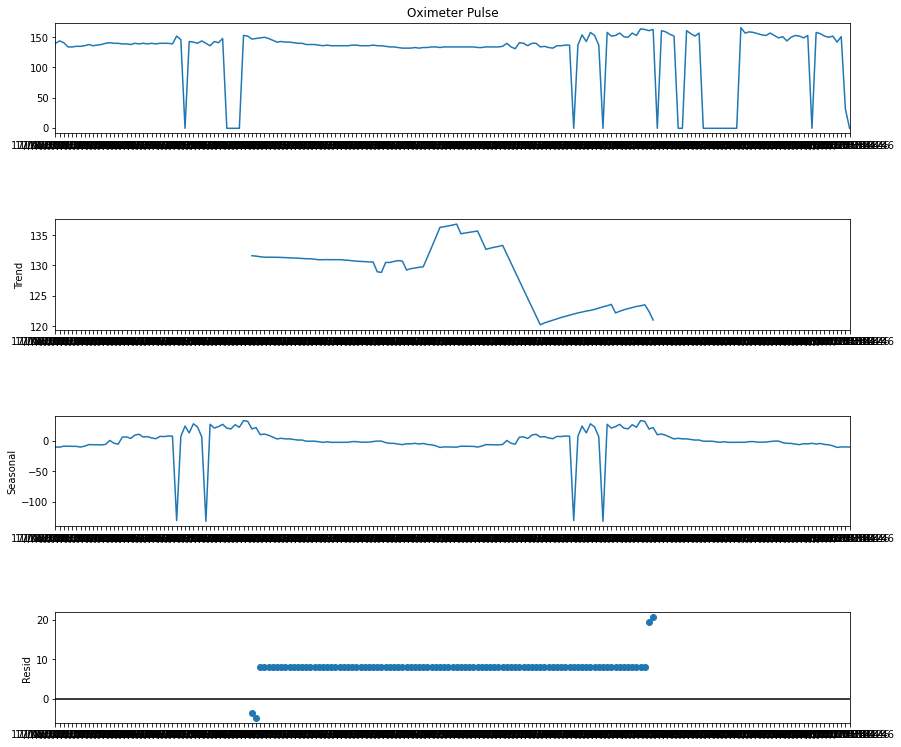

In [15]:
# Performing Seasonsal Decomposition for all features. Seasonal Decomposition separates the data based on a...
# ...repetitive pattern called season.
pulse = seasonal_decompose(data['Oximeter Pulse'], model='additive', freq = 95)
fig = plt.figure()  
fig = pulse.plot()  
fig.set_size_inches(15, 12)

In [16]:
# Defining a function to test how stationary is the timeseries data we have since it is mandatory to have a stationary...
# ...timeseries dataset if prediction is the aim.
def test_stationarity(timeseries, window = 12, cutoff = 0.01):

    # Determining rolling statistics
    rolmean = timeseries.rolling(window).mean()
    rolstd = timeseries.rolling(window).std()

    # Plot rolling statistics
    fig = plt.figure(figsize=(12, 8))
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show()
    
    # Performing Dickey-Fuller test
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC', maxlag = 20 )
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    pvalue = dftest[1]
    if pvalue < cutoff:
        print('p-value = %.4f. The series is likely stationary.' % pvalue)
    else:
        print('p-value = %.4f. The series is likely non-stationary.' % pvalue)
    
    print(dfoutput)

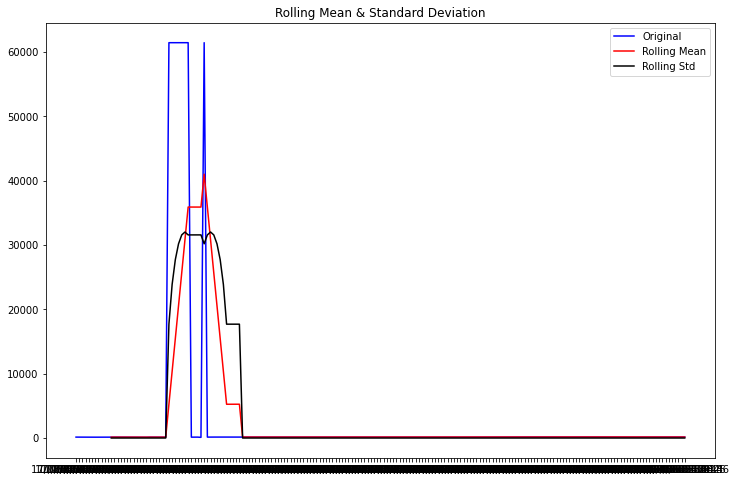

Results of Dickey-Fuller Test:
p-value = 0.0071. The series is likely stationary.
Test Statistic                  -3.535968
p-value                          0.007110
#Lags Used                      11.000000
Number of Observations Used    179.000000
Critical Value (1%)             -3.467420
Critical Value (5%)             -2.877826
Critical Value (10%)            -2.575452
dtype: float64


In [17]:
# Testing Stationarity for each feature
test_stationarity(data['Lifetouch Heart Rate'])

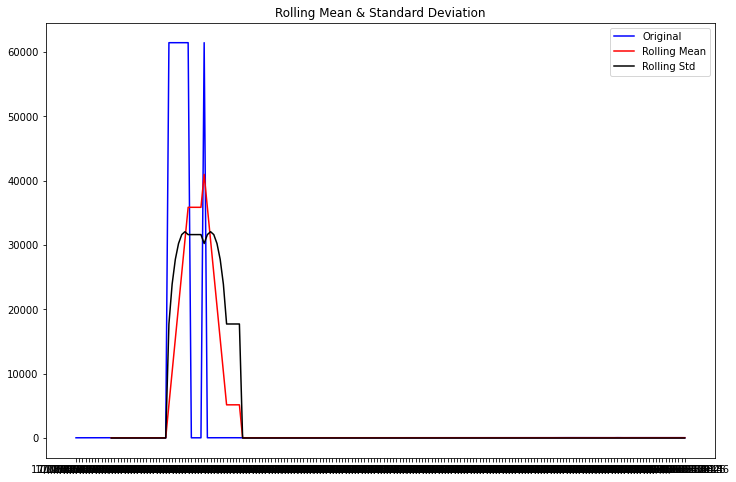

Results of Dickey-Fuller Test:
p-value = 0.0071. The series is likely stationary.
Test Statistic                  -3.535247
p-value                          0.007127
#Lags Used                      11.000000
Number of Observations Used    179.000000
Critical Value (1%)             -3.467420
Critical Value (5%)             -2.877826
Critical Value (10%)            -2.575452
dtype: float64


In [18]:
# Testing Stationarity for each feature
test_stationarity(data['Lifetouch Respiration Rate'])

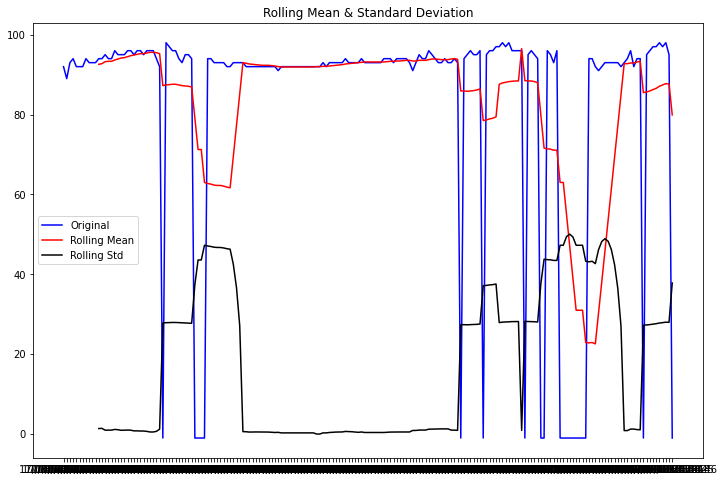

Results of Dickey-Fuller Test:
p-value = 0.0000. The series is likely stationary.
Test Statistic                -7.282114e+00
p-value                        1.491024e-10
#Lags Used                     0.000000e+00
Number of Observations Used    1.900000e+02
Critical Value (1%)           -3.465244e+00
Critical Value (5%)           -2.876875e+00
Critical Value (10%)          -2.574945e+00
dtype: float64


In [19]:
# Testing Stationarity for each feature
test_stationarity(data['Oximeter SpO2'])

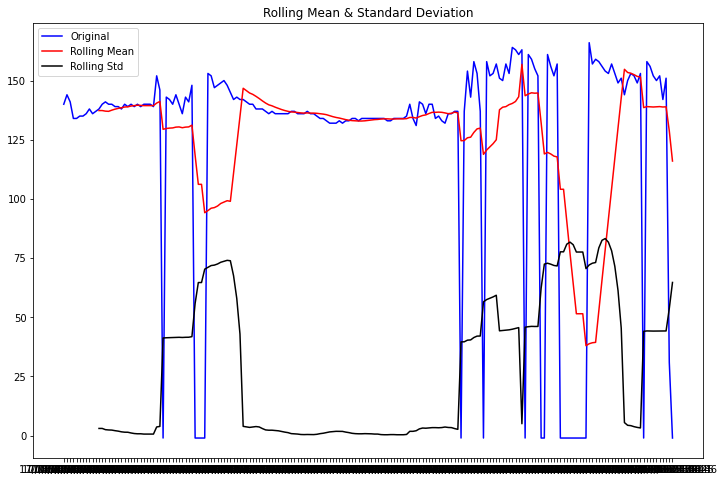

Results of Dickey-Fuller Test:
p-value = 0.0000. The series is likely stationary.
Test Statistic                -7.509266e+00
p-value                        4.056232e-11
#Lags Used                     0.000000e+00
Number of Observations Used    1.900000e+02
Critical Value (1%)           -3.465244e+00
Critical Value (5%)           -2.876875e+00
Critical Value (10%)          -2.574945e+00
dtype: float64


In [20]:
# Testing Stationarity for each feature
test_stationarity(data['Oximeter Pulse'])

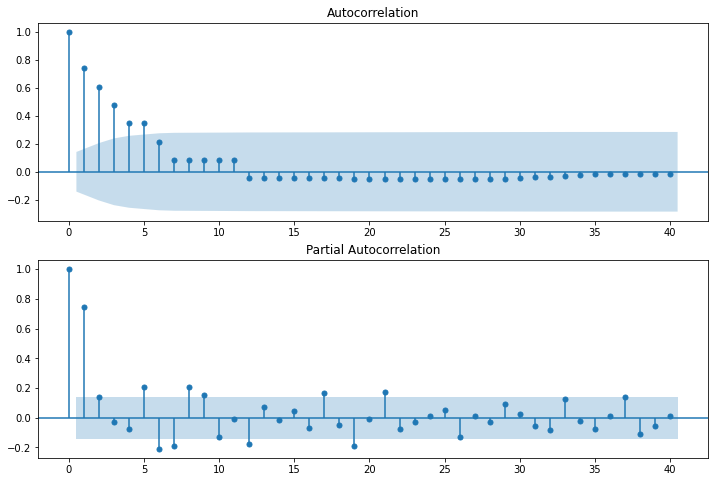

In [21]:
# For the Application of ARIMA, the determination of the parameters p, d and q are extremely necessary. This is done for...
# ...all features.
fig = plt.figure(figsize = (12, 8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(data['Lifetouch Heart Rate'], lags = 40, ax = ax1) # Q
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(data['Lifetouch Heart Rate'], lags = 40, ax = ax2) # P

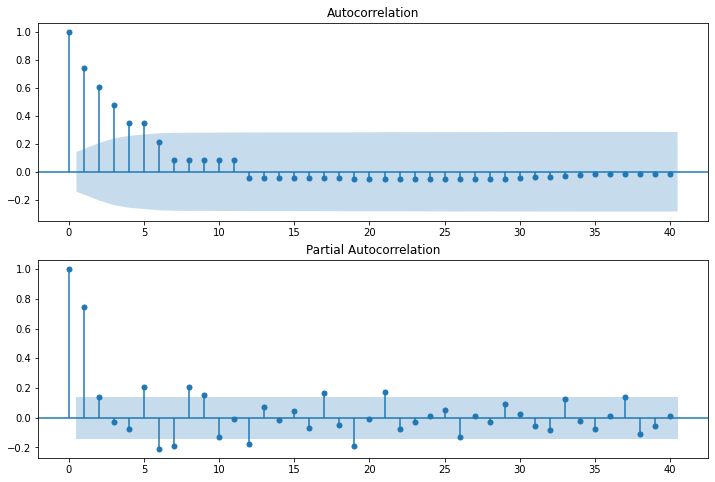

In [22]:
# For the Application of ARIMA, the determination of the parameters p, d and q are extremely necessary. This is done for...
# ...all features.
fig = plt.figure(figsize = (12, 8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(data['Lifetouch Respiration Rate'], lags = 40, ax = ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(data['Lifetouch Respiration Rate'], lags = 40, ax = ax2)

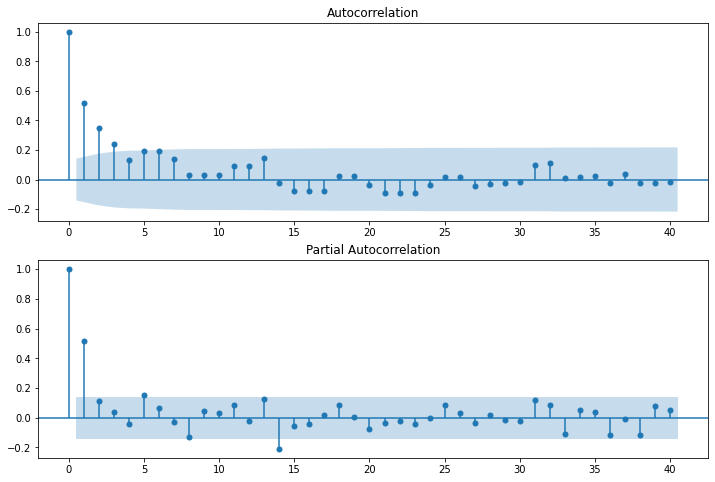

In [23]:
# For the Application of ARIMA, the determination of the parameters p, d and q are extremely necessary. This is done for...
# ...all features.
fig = plt.figure(figsize = (12, 8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(data['Oximeter SpO2'], lags = 40, ax = ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(data['Oximeter SpO2'], lags = 40, ax = ax2)

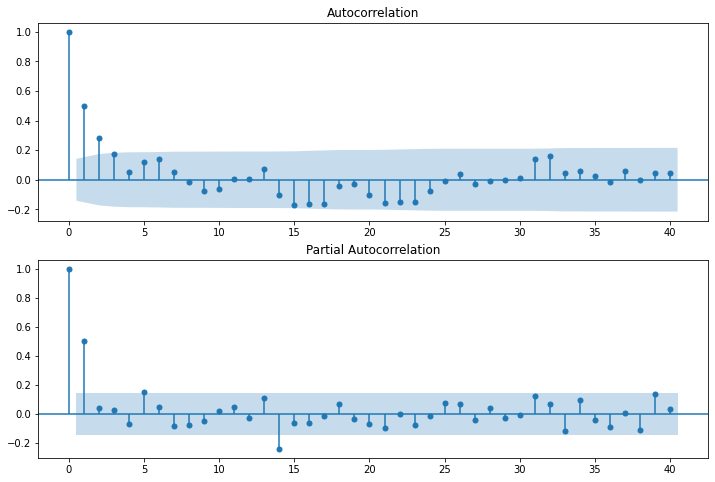

In [24]:
# For the Application of ARIMA, the determination of the parameters p, d and q are extremely necessary. This is done for...
# ...all features.
fig = plt.figure(figsize = (12, 8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(data['Oximeter Pulse'], lags = 40, ax = ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(data['Oximeter Pulse'], lags = 40, ax = ax2)

NormaltestResult(statistic=152.9487349032018, pvalue=6.132029122084391e-34)


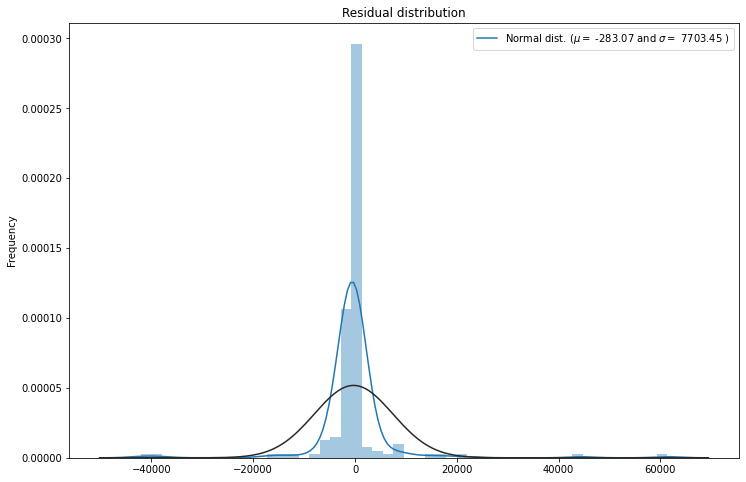

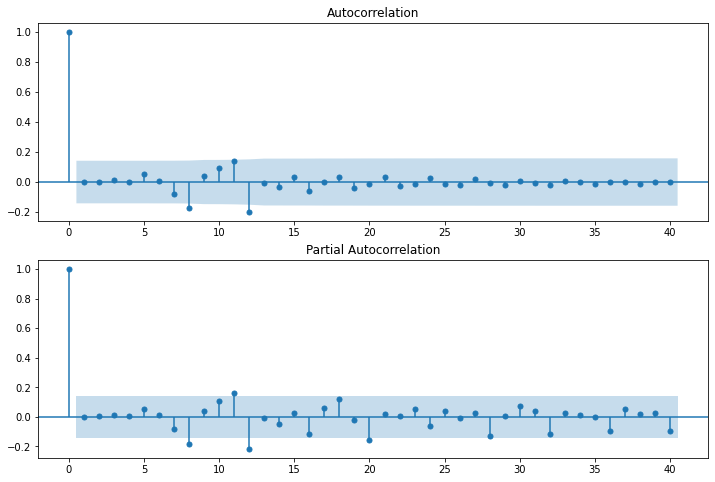

In [25]:
# Defining the SARIMAX model. Chosen SARIMAX due to a definitive pattern emerging the acf and pacf graphs of all features.
heart_rate_arima = SARIMAX(data['Lifetouch Heart Rate'], trend = 'n', order = (6, 1, 3)).fit()

# Plotting a distribution curve and acf, pacf curves again to check the behaviour of the algorithm with the dataset.
resid = heart_rate_arima.resid
print(normaltest(resid))

fig = plt.figure(figsize = (12, 8))
ax0 = fig.add_subplot(111)

sns.distplot(resid ,fit = stats.norm, ax = ax0)
(mu, sigma) = stats.norm.fit(resid)

plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)], loc='best')
plt.ylabel('Frequency')
plt.title('Residual distribution')

fig = plt.figure(figsize = (12, 8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(heart_rate_arima.resid, lags = 40, ax = ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(heart_rate_arima.resid, lags = 40, ax = ax2)

NormaltestResult(statistic=153.01342012534437, pvalue=5.9368761782504946e-34)


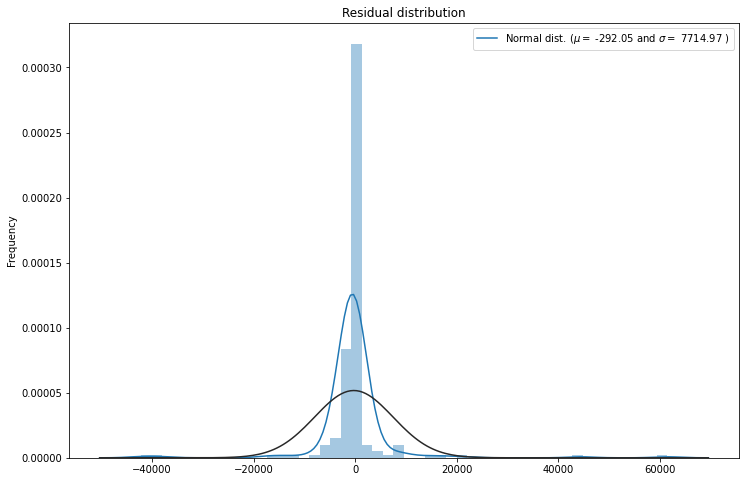

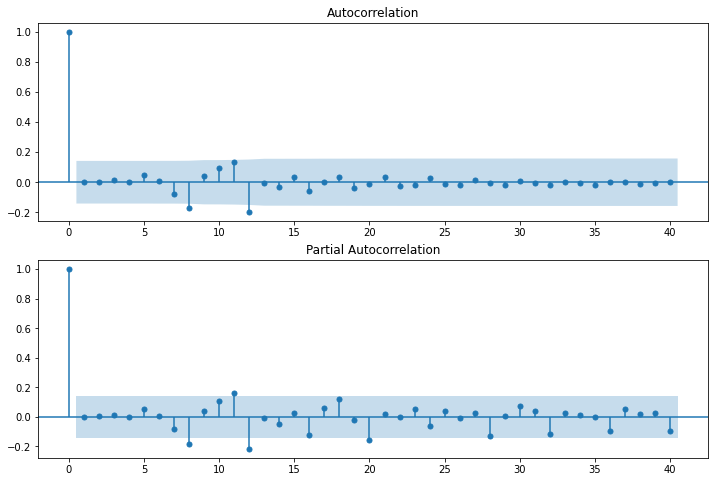

In [26]:
resp_arima = SARIMAX(data['Lifetouch Respiration Rate'], trend = 'n', order = (6, 1, 3)).fit()

resid = resp_arima.resid
print(normaltest(resid))

fig = plt.figure(figsize = (12, 8))
ax0 = fig.add_subplot(111)

sns.distplot(resid ,fit = stats.norm, ax = ax0)
(mu, sigma) = stats.norm.fit(resid)

plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)], loc = 'best')
plt.ylabel('Frequency')
plt.title('Residual distribution')

fig = plt.figure(figsize = (12, 8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(resp_arima.resid, lags = 40, ax = ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(resp_arima.resid, lags = 40, ax = ax2)

NormaltestResult(statistic=73.40395967703842, pvalue=1.1495627462094635e-16)


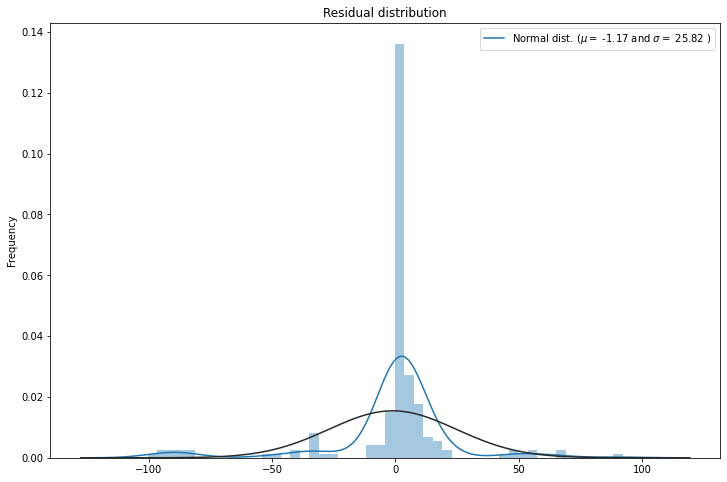

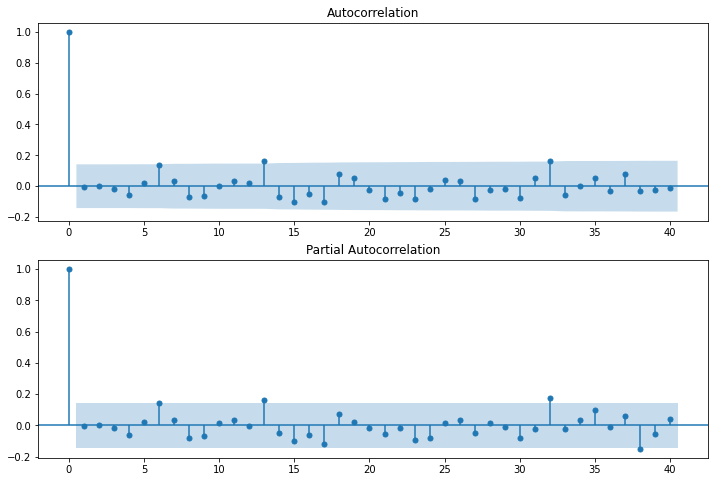

In [27]:
spo2_arima = SARIMAX(data['Oximeter SpO2'], trend = 'n', order = (4, 1, 2)).fit()

resid = spo2_arima.resid
print(normaltest(resid))

fig = plt.figure(figsize = (12, 8))
ax0 = fig.add_subplot(111)

sns.distplot(resid ,fit = stats.norm, ax = ax0)
(mu, sigma) = stats.norm.fit(resid)

plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)], loc='best')
plt.ylabel('Frequency')
plt.title('Residual distribution')

fig = plt.figure(figsize = (12, 8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(spo2_arima.resid, lags = 40, ax = ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(spo2_arima.resid, lags = 40, ax = ax2)

NormaltestResult(statistic=61.13370192278123, pvalue=5.308664730908876e-14)


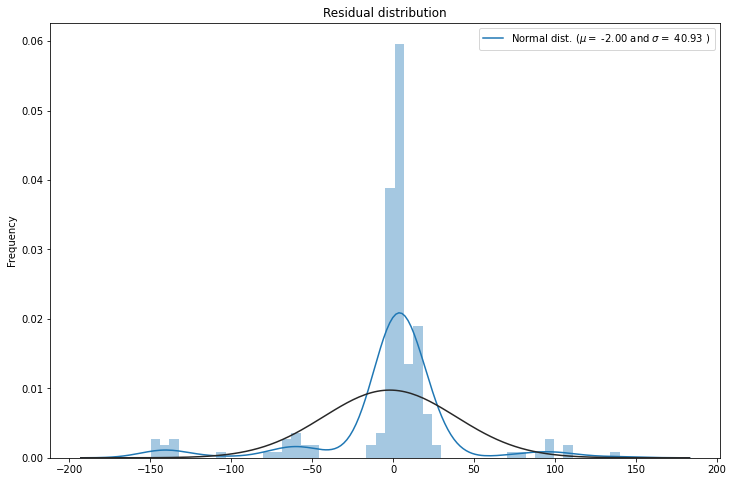

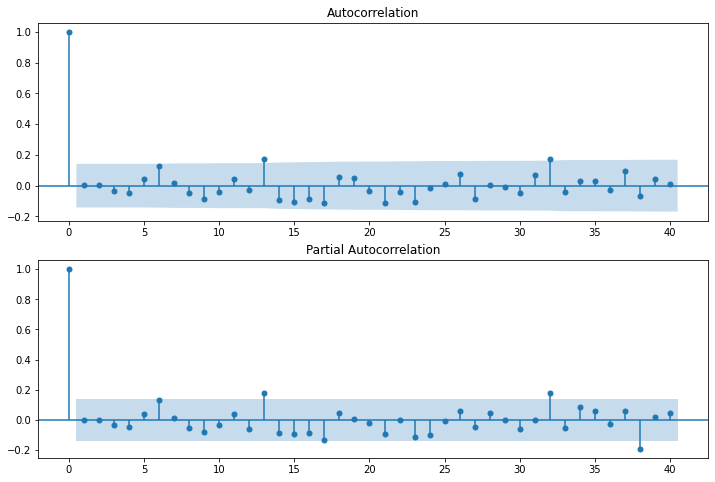

In [28]:
pulse_arima = SARIMAX(data['Oximeter Pulse'], trend = 'n', order = (4, 1, 2)).fit()

resid = pulse_arima.resid
print(normaltest(resid))

fig = plt.figure(figsize = (12, 8))
ax0 = fig.add_subplot(111)

sns.distplot(resid ,fit = stats.norm, ax = ax0)
(mu, sigma) = stats.norm.fit(resid)

plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)], loc='best')
plt.ylabel('Frequency')
plt.title('Residual distribution')

fig = plt.figure(figsize = (12, 8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(pulse_arima.resid, lags = 40, ax = ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(pulse_arima.resid, lags = 40, ax = ax2)

In [29]:
# Predicting all features using the trained algorithm
heart_rate_pred = heart_rate_arima.predict()
resp_pred = resp_arima.predict()
spo2_pred = spo2_arima.predict()
pulse_pred = pulse_arima.predict()

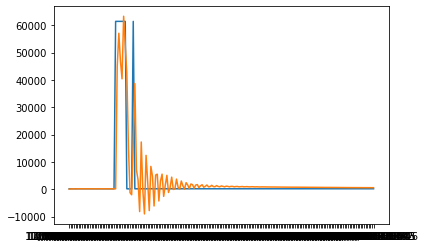

In [30]:
# Comparing performance using a graph. The blue line is the original reading, the orange line is the prediction.
# as it can be seen, the prediction is close but has a lot more fluctuations than the original.
plt.plot(data['Lifetouch Heart Rate'])
plt.plot(heart_rate_pred)

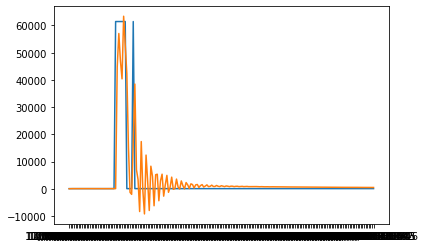

In [31]:
# Comparing performance using a graph. The blue line is the original reading, the orange line is the prediction.
# as it can be seen, the prediction is close but has a lot more fluctuations than the original.
plt.plot(data['Lifetouch Respiration Rate'])
plt.plot(resp_pred)

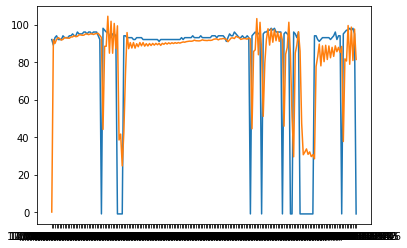

In [32]:
# Comparing performance using a graph. The blue line is the original reading, the orange line is the prediction.
# as it can be seen, the prediction is close but has a lot more fluctuations than the original.
plt.plot(data['Oximeter SpO2'])
plt.plot(spo2_pred)

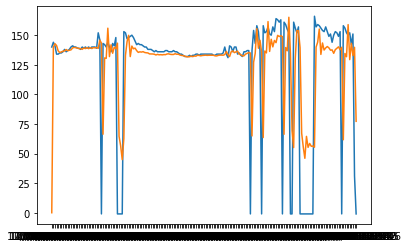

In [33]:
# Comparing performance using a graph. The blue line is the original reading, the orange line is the prediction.
# as it can be seen, the prediction is close but has a lot more fluctuations than the original.
plt.plot(data['Oximeter Pulse'])
plt.plot(pulse_pred)